In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv("./Outputs/final.csv", header=0)
print(f"Original data shape: {df.shape}")

Original data shape: (2055, 12)


In [11]:
df_filtered = df.drop(columns=["Image_Path"])
print(f"Filtered data shape: {df_filtered.shape}")

mask_no_face = (df['FACIAL_DISPLAYED'] == 0)
mask_no_pose = (df['POSE_DISPLAYED'] == 0)

Filtered data shape: (2055, 11)


In [12]:
df_filtered.loc[(mask_no_face & mask_no_pose) | (mask_no_face), 'LABEL'] = 3

print(f"Rows labeled as 'No Detection' (Label 3): {df_filtered[df_filtered['LABEL'] == 3].shape[0]}")

Rows labeled as 'No Detection' (Label 3): 237


In [13]:
df_clean = df_filtered.replace(-999.0, 0.0)
if 'Image_Path' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Image_Path'])
print("Data processed. -999.0 replaced with 0.0.")

Data processed. -999.0 replaced with 0.0.


In [21]:
# Separate Features and Target
X = df_clean.drop(columns=['LABEL'])
y = df_clean['LABEL']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

num_classes = y.nunique()
print(f"Number of classes: {num_classes} (Expected 4)")

y_encoded = to_categorical(y, num_classes=num_classes)

# Split into Train (70%), Validation (15%), and Test (15%)
# Stratify ensures we have examples of Label 3 in all sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

Number of classes: 4 (Expected 4)


PLOT EVALUATION GRAPH

In [15]:
def plot_history(history):
    # Create a figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    keys = list(history.history.keys())
    # Plot Loss (Always present)
    ax1.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.legend()
    ax1.grid(True)

    if 'accuracy' in keys:
        metric = 'accuracy'
        label = 'Accuracy'
    elif 'mae' in keys:
        metric = 'mae'
        label = 'MAE'
    else:
        metric = None

    if metric:
        ax2.plot(history.history[metric], label=f'Train {label}')
        if f'val_{metric}' in history.history:
            ax2.plot(history.history[f'val_{metric}'], label=f'Val {label}')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel(label)
        ax2.set_title(f'Training & Validation {label}')
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.axis('off') # Hide if no secondary metric found

    plt.show()

DEFINE MODEL BEFORE TRAINING

In [16]:
n_feature = X_train.shape[1]
n_output = y_encoded.shape[1] 

def train_model(x_train, y_train, x_valid, y_valid,
                num_nodes, dropout_prob, lr, batch_size, epochs):
    # Build model (Classification architecture for your problem)
    # Note: Modified to use 'softmax' output for Classification as per your earlier cells
    nn_model = Sequential([
        Dense(num_nodes, activation='relu', input_shape=(n_feature,)),
        Dropout(dropout_prob),
        Dense(num_nodes, activation='relu'),
        Dropout(dropout_prob),
        Dense(n_output, activation='softmax') # Use softmax for multi-class classification
    ])

    # Compile
    nn_model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy', # Use Cat Crossentropy for Classification
        metrics=['accuracy']             # Monitor Accuracy
    )
    
    # Early Stopping
    early_stop = EarlyStopping(
        monitor='val_loss',       # what metric to watch
        patience=10,              # how many epochs to wait (reduced to 10 for faster iterating)
        restore_best_weights=True # revert to best weights
    )

    # Train
    history = nn_model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0 # Silent training
    )
    # Extract final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"   -> Final Train Loss: {final_train_loss:.4f}, Acc: {final_train_acc:.4f}")
    print(f"   -> Final Val Loss:   {final_val_loss:.4f}, Acc: {final_val_acc:.4f}")

    return nn_model, history

print("Training functions defined.")

Training functions defined.


INITIATE TRAINING

Starting Grid Search on 36 combinations...

[1/36] Testing: Nodes=32 | Dropout=0.1 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.1648, Acc: 0.9430
   -> Final Val Loss:   0.1857, Acc: 0.9416
   *** NEW BEST MODEL FOUND *** (Val Loss: 0.1083)


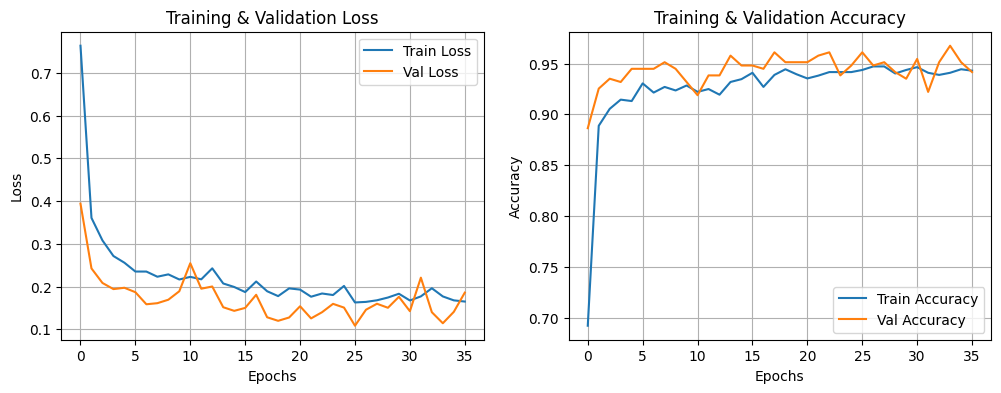


[2/36] Testing: Nodes=32 | Dropout=0.1 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.1515, Acc: 0.9444
   -> Final Val Loss:   0.1145, Acc: 0.9610
   *** NEW BEST MODEL FOUND *** (Val Loss: 0.1013)


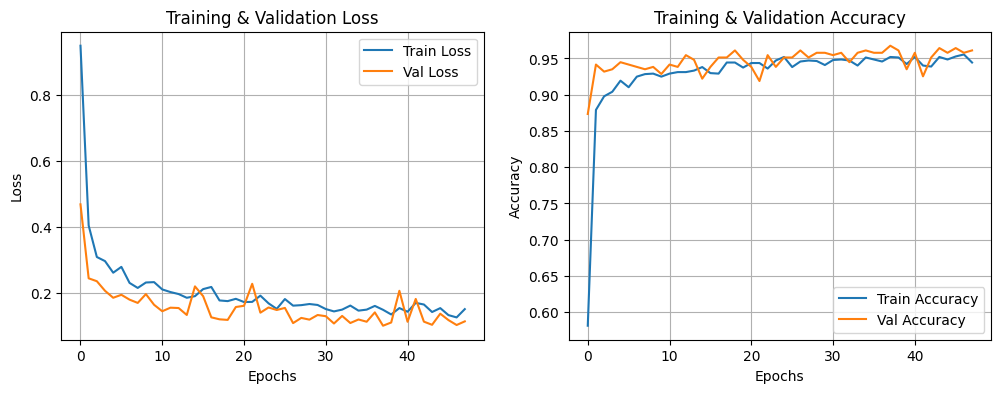


[3/36] Testing: Nodes=32 | Dropout=0.1 | LR=0.001 | Batch=16
   -> Final Train Loss: 0.1555, Acc: 0.9513
   -> Final Val Loss:   0.1293, Acc: 0.9578

[4/36] Testing: Nodes=32 | Dropout=0.1 | LR=0.001 | Batch=32
   -> Final Train Loss: 0.1638, Acc: 0.9437
   -> Final Val Loss:   0.1347, Acc: 0.9610

[5/36] Testing: Nodes=32 | Dropout=0.3 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.2562, Acc: 0.9179
   -> Final Val Loss:   0.1793, Acc: 0.9351

[6/36] Testing: Nodes=32 | Dropout=0.3 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.2262, Acc: 0.9256
   -> Final Val Loss:   0.1532, Acc: 0.9383

[7/36] Testing: Nodes=32 | Dropout=0.3 | LR=0.001 | Batch=16
   -> Final Train Loss: 0.2286, Acc: 0.9228
   -> Final Val Loss:   0.1593, Acc: 0.9481

[8/36] Testing: Nodes=32 | Dropout=0.3 | LR=0.001 | Batch=32
   -> Final Train Loss: 0.2331, Acc: 0.9332
   -> Final Val Loss:   0.1547, Acc: 0.9481

[9/36] Testing: Nodes=32 | Dropout=0.5 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.4114, Acc: 0.87

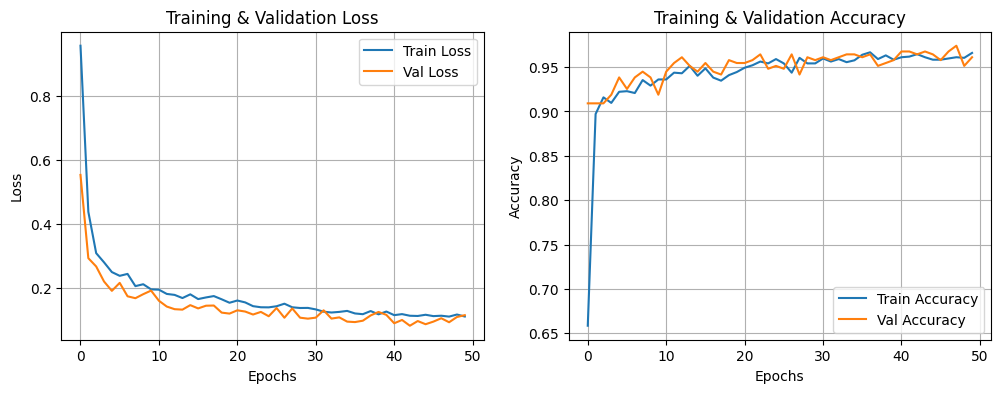


[28/36] Testing: Nodes=128 | Dropout=0.1 | LR=0.001 | Batch=32
   -> Final Train Loss: 0.1158, Acc: 0.9611
   -> Final Val Loss:   0.0882, Acc: 0.9708

[29/36] Testing: Nodes=128 | Dropout=0.3 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.2064, Acc: 0.9242
   -> Final Val Loss:   0.1666, Acc: 0.9383

[30/36] Testing: Nodes=128 | Dropout=0.3 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.1794, Acc: 0.9444
   -> Final Val Loss:   0.1276, Acc: 0.9610

[31/36] Testing: Nodes=128 | Dropout=0.3 | LR=0.001 | Batch=16
   -> Final Train Loss: 0.1366, Acc: 0.9478
   -> Final Val Loss:   0.1082, Acc: 0.9675

[32/36] Testing: Nodes=128 | Dropout=0.3 | LR=0.001 | Batch=32
   -> Final Train Loss: 0.1268, Acc: 0.9583
   -> Final Val Loss:   0.0991, Acc: 0.9643

[33/36] Testing: Nodes=128 | Dropout=0.5 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.4048, Acc: 0.8769
   -> Final Val Loss:   0.2204, Acc: 0.9188

[34/36] Testing: Nodes=128 | Dropout=0.5 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.27

In [ ]:
least_val_loss = float('inf')
least_loss_model = None
best_nn_model_config = None
epochs = 50  # Set max epochs

# Search Grid
node_counts = [32, 64, 128]
dropout_probs = [0.1, 0.3, 0.5]
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]

total_runs = len(node_counts) * len(dropout_probs) * len(learning_rates) * len(batch_sizes)
current_run = 0

print(f"Starting Grid Search on {total_runs} combinations...")

for num_nodes in node_counts:
    for dropout_prob in dropout_probs:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                current_run += 1
                print(f"\n[{current_run}/{total_runs}] Testing: Nodes={num_nodes} | Dropout={dropout_prob} | LR={lr} | Batch={batch_size}")
                
                # Call the train function
                model, history = train_model(
                    X_train, y_train,
                    X_val, y_val,
                    num_nodes, dropout_prob, lr, batch_size, epochs
                )

                # Optional: Plot history for every single model (can get spammy, maybe only plot best?)
                # plot_history(history) 
                
                # Evaluate
                val_loss = min(history.history['val_loss']) # Use min loss achieved during training
                
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model
                    
                    best_nn_model_config = {
                        'num_nodes': num_nodes,
                        'dropout_prob': dropout_prob,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'epochs': len(history.history['loss']), # Actual epochs run
                        'val_loss': round(val_loss, 5)
                    }
                       
                    print(f"   *** NEW BEST MODEL FOUND *** (Val Loss: {least_val_loss:.4f})")
                    # Plot the history only for new best models to save space65
                    plot_history(history)

print("\nHyperparameter tuning complete.")
print(f"Best Configuration: {best_nn_model_config}")

LOAD MODEL

In [7]:
model_path = './Outputs/drowsiness_model.h5'
if os.path.exists(model_path):
    least_loss_model = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
    least_loss_model.summary()
else:
    raise FileNotFoundError(f"Model file not found: {model_path}")

Loaded model from ./Outputs/drowsiness_model.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,126 (426.28 KB)

 Trainable params: 109,124 (426.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
# Inspect saved model and dataset shapes to plan reshaping
print('Model input shape:', getattr(least_loss_model, 'input_shape', 'N/A'))
print('Model output shape:', getattr(least_loss_model, 'output_shape', 'N/A'))
print('\nModel layers:')
for i, layer in enumerate(least_loss_model.layers):
    print(i, layer.__class__.__name__, getattr(layer, 'input_shape', None), getattr(layer, 'output_shape', None))

print('\nDataset feature shapes:')
try:
    print('X shape:', X.shape)
    print('X columns (first 50):', list(X.columns)[:50])
except Exception as e:
    print('Could not show X columns:', e)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('n_feature variable:', n_feature)

# Show a few rows of the raw dataframe to look for grouping identifiers (video, timestamp, subject)
print('\ndf columns (first 50):', list(df.columns)[:50])
display(df.head())

Model input shape: (None, 30, 9)
Model output shape: (None, 4)

Model layers:
0 Conv1D None None
1 MaxPooling1D None None
2 LSTM None None
3 Dropout None None
4 Dense None None
5 Dropout None None
6 Dense None None

Dataset feature shapes:
X shape: (2055, 10)
X columns (first 50): ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'D_SLUMP', 'R_TILT', 'EYE_CL', 'FACIAL_DISPLAYED', 'POSE_DISPLAYED']
X_train shape: (1438, 10)
X_val shape: (308, 10)
X_test shape: (309, 10)
n_feature variable: 10

df columns (first 50): ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'D_SLUMP', 'R_TILT', 'EYE_CL', 'FACIAL_DISPLAYED', 'POSE_DISPLAYED', 'LABEL', 'Image_Path']


,EAR,MAR,PITCH,YAW,ROLL,D_SLUMP,R_TILT,EYE_CL,FACIAL_DISPLAYED,POSE_DISPLAYED,LABEL,Image_Path
0,0.3331,0.5861,31.6382,-5.2346,-5.0504,1.0640,0.5070,0.0621,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
1,0.2696,0.2103,23.0431,-1.6258,-0.4376,0.9222,-1.8882,0.0536,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
2,0.4142,0.2831,145.9168,0.9384,-1.5578,0.7423,-1.2571,0.0878,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
3,0.4271,0.2635,32.7882,-25.6324,3.5415,1.0925,4.0142,0.0811,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
4,0.3590,0.2906,57.2217,-1.0224,-0.2451,0.9877,0.7673,0.0683,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...


array([[0.29816107, 0.81582663, 0.0944036 , ..., 0.5022779 , 1.        ,
        1.        ],
       [0.38528852, 0.17363676, 0.24741036, ..., 0.70501139, 1.        ,
        1.        ],
       [0.08192771, 0.20573539, 0.24252442, ..., 0.15489749, 1.        ,
        1.        ],
       ...,
       [0.36613824, 0.20774495, 0.22801902, ..., 0.65375854, 1.        ,
        1.        ],
       [0.10615092, 0.1729307 , 0.30824751, ..., 0.18906606, 1.        ,
        1.        ],
       [0.51528218, 0.2648816 , 0.17039719, ..., 0.63439636, 1.        ,
        1.        ]], shape=(309, 10))

In [ ]:
#y_result = least_loss_model.predict(X_test)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 10), dtype=float32). Expected shape (None, 30, 9), but input has incompatible shape (32, 10)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 10), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

Model expects sequences: seq_len=30, feat_count=9
Data has 10 features; keeping first 9 columns: ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'D_SLUMP', 'R_TILT', 'EYE_CL', 'FACIAL_DISPLAYED']
Created 280 sequences with shape (280, 30, 9)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Sequence Test Accuracy: 0.0571 (5.71%) on 280 sequences

Classification report (sequences):
              precision    recall  f1-score   support

           0     0.0571    1.0000    0.1081        16
           1     0.0000    0.0000    0.0000        21
           2     0.0000    0.0000    0.0000       243

    accuracy                         0.0571       280
   macro avg     0.0190    0.3333    0.0360       280
weighted avg     0.0033    0.0571    0.0062       280

Saved sequence-level predictions to ./Outputs/test_predictions_sequences.csv


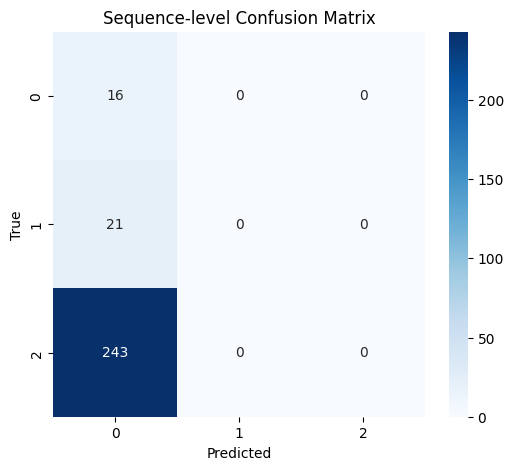

Number of misclassified sequences: 264 / 280


,start_idx,true,pred,pred_prob_max,prob_0,prob_1,prob_2,prob_3
0,0,2,0,0.999997,0.999997,0.000003,8.882482e-11,1.734185e-08
1,1,2,0,0.999998,0.999998,0.000002,3.428323e-11,4.419793e-09
2,2,2,0,0.999998,0.999998,0.000002,4.991147e-11,8.504173e-09
3,3,2,0,0.999998,0.999998,0.000002,3.192625e-11,4.974457e-09
4,4,2,0,0.999998,0.999998,0.000002,5.055764e-11,1.177840e-08
5,5,2,0,0.999998,0.999998,0.000002,3.133072e-11,6.513967e-09
6,6,2,0,0.999999,0.999999,0.000001,3.048458e-11,9.867508e-09
7,7,2,0,0.999999,0.999999,0.000001,2.298562e-11,7.347667e-09
8,8,2,0,0.999999,0.999999,0.000001,2.432113e-11,6.740412e-09
9,9,2,0,0.999999,0.999999,0.000001,2.187580e-11,7.329750e-09


In [ ]:
# # Prepare sequences from X_test to match model input (sequence length, features)
# #from tensorflow.keras.utils import to_categorical

# #model_input = least_loss_model.input_shape
# #if len(model_input) == 3 and X_test.ndim == 2:
# #    seq_len = model_input[1]
# #    feat_count = model_input[2]
# #    print(f"Model expects sequences: seq_len={seq_len}, feat_count={feat_count}")

#     # Build a DataFrame copy of test features for easier column handling
# #    df_test = pd.DataFrame(X_test, columns=X.columns)

#     # If more columns than expected, select the first `feat_count` columns (adjustable)
# #    if df_test.shape[1] > feat_count:
# #        keep_cols = list(df_test.columns[:feat_count])
# #        print(f"Data has {df_test.shape[1]} features; keeping first {feat_count} columns: {keep_cols}")
# #        df_test = df_test[keep_cols]
# #    elif df_test.shape[1] < feat_count:
# #        raise ValueError(f"Test data has {df_test.shape[1]} features but model expects {feat_count}; cannot auto-resolve.")

# #    def make_sequences_from_df(df_in, y_onehot, seq_len=30, stride=1):
# #        X_arr = df_in.values
# #        y_arg = np.argmax(y_onehot, axis=1)
# #        Xs = []
# #        ys = []
# #        starts = []
#         for start in range(0, len(X_arr) - seq_len + 1, stride):
#             Xs.append(X_arr[start:start + seq_len])
#             seq_labels = y_arg[start:start + seq_len]
#             vals, counts = np.unique(seq_labels, return_counts=True)
#             ys.append(vals[np.argmax(counts)])  # majority vote for sequence label
#             starts.append(start)
#         Xs = np.array(Xs)
#         ys = np.array(ys)
#         ys_onehot = to_categorical(ys, num_classes=n_output)
#         return Xs, ys_onehot, np.array(starts)

#     X_seq, y_seq_onehot, seq_starts = make_sequences_from_df(df_test, y_test, seq_len=seq_len, stride=1)
#     print(f"Created {X_seq.shape[0]} sequences with shape {X_seq.shape}")

#     # Predict on sequences
#     seq_preds_probs = least_loss_model.predict(X_seq)
#     seq_preds = np.argmax(seq_preds_probs, axis=1)
#     seq_true = np.argmax(y_seq_onehot, axis=1)

#     # Evaluate
#     seq_acc = np.mean(seq_preds == seq_true)
#     print(f"Sequence Test Accuracy: {seq_acc:.4f} ({seq_acc*100:.2f}%) on {len(seq_true)} sequences")
#     print('\nClassification report (sequences):')
#     print(classification_report(seq_true, seq_preds, digits=4))

#     # Save sequence-level predictions (include start index)
#     prob_cols = [f'prob_{i}' for i in range(seq_preds_probs.shape[1])]
#     df_seq_pred = pd.DataFrame({
#         'start_idx': seq_starts,
#         'true': seq_true,
#         'pred': seq_preds,
#         'pred_prob_max': np.max(seq_preds_probs, axis=1)
#     })
#     probs_df = pd.DataFrame(seq_preds_probs, columns=prob_cols)
#     df_seq_pred = pd.concat([df_seq_pred, probs_df], axis=1)
#     out_seq_path = './Outputs/test_predictions_sequences.csv'
#     df_seq_pred.to_csv(out_seq_path, index=False)
#     print(f"Saved sequence-level predictions to {out_seq_path}")

#     # Confusion matrix plot
#     cm = confusion_matrix(seq_true, seq_preds)
#     plt.figure(figsize=(6,5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title('Sequence-level Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()

#     # Show sample misclassified sequences
#     mis_idx = np.where(df_seq_pred['true'] != df_seq_pred['pred'])[0]
#     print(f"Number of misclassified sequences: {len(mis_idx)} / {len(seq_true)}")
#     if len(mis_idx) > 0:
#         n_show = min(10, len(mis_idx))
#         display(df_seq_pred.iloc[mis_idx][:n_show])
# else:
#     print('Model input and X_test shape are compatible or not sequence model; proceed with standard prediction flow.')

In [ ]:
# # Rebuild sequences grouped by recording (use Image_Path directory) and re-evaluate
# from collections import defaultdict

# seq_len = least_loss_model.input_shape[1]
# feat_count = least_loss_model.input_shape[2]
# feature_cols = list(X.columns)[:feat_count]

# # Recreate the same test split but keep row indices so we can group by Image_Path
# idx = np.arange(len(df_clean))
# train_idx, temp_idx = train_test_split(idx, test_size=0.3, random_state=42, stratify=y)
# val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, stratify=y[temp_idx])

# df_test = df_clean.iloc[test_idx].copy().reset_index(drop=True)
# df_test['group'] = df_test['Image_Path'].apply(lambda p: os.path.dirname(p))

# X_seq_list = []
# Y_seq_list = []
# start_idxs = []

# for grp, grp_df in df_test.groupby('group'):
#     grp_df = grp_df.reset_index(drop=True)
#     if len(grp_df) < seq_len:
#         continue
#     vals = scaler.transform(grp_df[feature_cols].values)
#     y_onehot = to_categorical(grp_df['LABEL'].values, num_classes=n_output)
#     # Slide within group
#     for s in range(0, len(vals) - seq_len + 1):
#         X_seq_list.append(vals[s:s+seq_len])
#         seg_labels = grp_df['LABEL'].values[s:s+seq_len]
#         lab_vals, lab_counts = np.unique(seg_labels, return_counts=True)
#         Y_seq_list.append(lab_vals[np.argmax(lab_counts)])
#         start_idxs.append((grp, s))

# if len(X_seq_list) == 0:
#     raise RuntimeError('No sequences were created — groups may be too short. Try lowering seq_len or inspecting Image_Path groups.')

# X_seq_grp = np.array(X_seq_list)
# Y_seq = np.array(Y_seq_list)
# Y_seq_onehot = to_categorical(Y_seq, num_classes=n_output)

# print(f'Built {X_seq_grp.shape[0]} grouped sequences with shape {X_seq_grp.shape}')

# # Predict and evaluate
# pred_probs = least_loss_model.predict(X_seq_grp)
# preds = np.argmax(pred_probs, axis=1)
# true = Y_seq

# acc = np.mean(preds == true)
# print(f'Grouped Sequence Accuracy: {acc:.4f} ({acc*100:.2f}%) on {len(true)} sequences')
# print('\nClassification report (grouped sequences):')
# print(classification_report(true, preds, digits=4))

# # Confusion matrix
# cm = confusion_matrix(true, preds)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Grouped Sequence Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Save grouped sequence predictions
# cols = [f'prob_{i}' for i in range(pred_probs.shape[1])]
# df_out = pd.DataFrame({
#     'group': [g for g, s in start_idxs],
#     'start': [s for g, s in start_idxs],
#     'true': true,
#     'pred': preds,
#     'pred_prob_max': np.max(pred_probs, axis=1)
# })
# df_out = pd.concat([df_out, pd.DataFrame(pred_probs, columns=cols)], axis=1)
# df_out.to_csv('./Outputs/test_predictions_grouped.csv', index=False)
# print('Saved grouped sequence predictions to ./Outputs/test_predictions_grouped.csv')

KeyError: 'Image_Path'

In [ ]:
# # Evaluate predictions vs. ground-truth
# # Convert predicted probabilities to class indices
# import numpy as np

# y_pred_probs = y_result
# y_pred = np.argmax(y_pred_probs, axis=1)
# y_true = np.argmax(y_test, axis=1)

# acc = np.mean(y_pred == y_true)
# print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")

# print('\nClassification report:')
# print(classification_report(y_true, y_pred, digits=4))

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Save detailed predictions to CSV (includes per-class probabilities)
# prob_cols = [f'prob_{i}' for i in range(y_pred_probs.shape[1])]
# df_pred = pd.DataFrame({
#     'true': y_true,
#     'pred': y_pred,
#     'pred_prob_max': np.max(y_pred_probs, axis=1)
# })
# probs_df = pd.DataFrame(y_pred_probs, columns=prob_cols)
# df_pred = pd.concat([df_pred, probs_df], axis=1)

# os.makedirs('./Outputs', exist_ok=True)
# out_path = './Outputs/test_predictions.csv'
# df_pred.to_csv(out_path, index=False)
# print(f"\nSaved test predictions to {out_path}")

# # Show some misclassified examples (if any)
# mis_idx = np.where(df_pred['true'] != df_pred['pred'])[0]
# print(f"\nNumber of misclassifications: {len(mis_idx)} / {len(y_true)}")
# if len(mis_idx) > 0:
#     n_show = min(10, len(mis_idx))
#     display(df_pred.iloc[mis_idx][:n_show])